This tutorial demonstrates how to create and train a sequence-to-sequence Transformer model to translate Portuguese into English. The Transformer was originally proposed in "Attention is all you need" by Vaswani et al. (2017).

A Transformer is a sequence-to-sequence encoder-decoder model similar to the model in the NMT with attention tutorial. A single-layer Transformer takes a little more code to write, but is almost identical to that encoder-decoder RNN model. The only difference is that the RNN layers are replaced with self attention layers. This tutorial builds a 4-layer Transformer which is larger and more powerful, but not fundamentally more complex.

<table>
<tr>
  <th>The <a href=https://www.tensorflow.org/text/tutorials/nmt_with_attention>RNN+Attention model</a></th>
  <th>A 1-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=411 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" alt="Attention heatmap">

# Setup

In [ ]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 21 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,392 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 11s (40.0 MB/s)
(Reading database ... 129504 files and directories currently installed.)
Removing libcudnn8-dev (8.1.1.33-1+cuda11.2) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.1.1.33-1+cuda11.2 to 8.1.0.77-1+cuda11.2
(Reading database ... 129481 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_text

# Data handling

## Download the dataset

Use TensorFlow Datasets to load the Portuguese-English translation datasetD Talks Open Translation Project. This dataset contains approximately 52,000 training, 1,200 validation and 1,800 test examples.

In [ ]:
examples, metadata = tfds.load(
    'ted_hrlr_translate/pt_to_en',
    with_info=True,
    as_supervised=True,
)

train_examples, val_examples = examples['train'], examples['validation'] #there is also examples['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteGAFWFH/ted_hrlr_translate-trai…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteGAFWFH/ted_hrlr_translate-vali…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteGAFWFH/ted_hrlr_translate-test…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


The tf.data.Dataset object returned by TensorFlow Datasets yields pairs of text examples:

In [ ]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


## Setup the tokenizer

Now that you have loaded the dataset, you need to tokenize the text, so that each element is represented as a token or token ID (a numeric representation).

In [ ]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

184801/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [ ]:
tokenizers = tf.saved_model.load(model_name)

The tf.saved_model contains two text tokenizers, one for English and one for Portuguese. Both have the same methods:

In [ ]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The tokenize method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing. That standardization is not visible here because the input data is already standardized.

In [ ]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [ ]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


The detokenize method attempts to convert these token IDs back to human-readable text:

In [ ]:
detokenize = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in detokenize.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


The lower level lookup method converts from token-IDs to token text:

In [ ]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

In [ ]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

...................................................

Text(0.5, 1.0, 'Maximun tokens per example: 320')

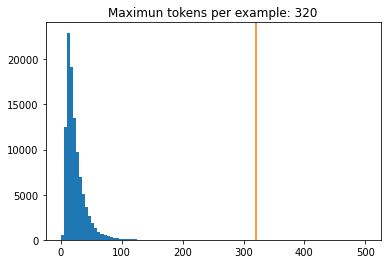

In [ ]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximun tokens per example: {max_length}')

## Setup a data pipeline with tf.data

The following function takes batches of text as input, and converts them to a format suitable for training.

1.   It tokenizes them into ragged batches.
2.   It trims each to be no longer than MAX_TOKENS.
3.   It splits the target (English) tokens into inputs and labels. These are shifted by one step so that at each input location the label is the id of the next token.
4.   It converts the RaggedTensors to padded dense Tensors.
5.   It returns an (inputs, labels) pair.

In [ ]:
MAX_TOKENS = 128

def prepare_batch(pt, en):
  pt = tokenizers.pt.tokenize(pt)     # Output is ragged
  pt = pt[:, :MAX_TOKENS]             # Trim to MAX_TOKENS
  pt = pt.to_tensor()                 # Convert to 0-padded dense tensor

  en = tokenizers.en.tokenize(en)
  en = en[:, :(MAX_TOKENS+1)]         # Shifted tensor
  en_inputs = en[:, :-1].to_tensor()  # Drop the [END] token
  en_labels = en[:, 1:].to_tensor()    # Drop the [START] token

  return (pt, en_inputs), en_labels

The function below converts a dataset of text examples into data of batches for training.

1.   It tokenizes the text, and filters out the sequences that are too long. (The batch/unbatch is included because the tokenizer is much more efficient on large batches).
2.   The cache method ensures that that work is only executed once.
3.   Then shuffle and, dense_to_ragged_batch randomize the order and assemble batches of examples.
4.   Finally prefetch runs the dataset in parallel with the model to ensure that data is available when needed.

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [ ]:
def make_batches(ds):
  return(
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size = tf.data.AUTOTUNE)
  )

# Test the Dataset

In [ ]:
# Create training and validation set batches
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

The resulting `tf.data.Dataset` objects are setup for training with Keras.
Keras `Model.fit` training expects `(inputs, labels)` pairs.
The `inputs` are pairs of tokenized Portuguese and English sequences, `(pt, en)`.
The `labels` are the same English sequences shifted by 1.
This shift is so that at each location input `en` sequence, the `label` in the next token.

<table>
<tr>
  <th>Inputs at the bottom, labels at the top.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

This setup is called "teacher forcing" because regardless of the model's output at each timestep, it gets the true value as input for the next timestep. This is a simple and efficient way to train a text generation model. It's efficient because you don't need to run the model sequentially, the outputs at the different sequence locations can be computed in parallel.

You might have expected the input, output, pairs to simply be the Protugese, English sequences. Given the Portuguese sequence, the model would try to generate the English sequence.

It's possible to train a model that way. You'd need to write out the inference loop and pass the model's output back to the input. It's slower (time steps can't run in parallel), and a harder task to learn (the model can't get the end of a sentence right until it gets the beginning right), but it can give a more stable model because the model has to learn to correct its own errors during training.

In [ ]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 73)
(64, 81)
(64, 81)


The en and en_labels are the same, just shifted by 1:

In [ ]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([   2  245 1023 1411  429   74  997  104   80   75], shape=(10,), dtype=int64)
tf.Tensor([ 245 1023 1411  429   74  997  104   80   75   83], shape=(10,), dtype=int64)


# Define the components

There's a lot going on inside a Transformer. The important things to remember are:

1.   It follows the same general pattern as a standard sequence-to-sequence model with an encoder and a decoder.
2.   If you work through it step by step it will all make sense.

<table>
<tr>
  <th colspan=1>The original Transformer diagram</th>
  <th colspan=1>A representation of a 4-layer Transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>

Each of the components in these two diagrams will be explained as you progress through the tutorial.

## The embedding and positional encoding layer

The inputs to both the encoder and decoder use the same embedding and positional encoding logic.

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
  </td>
</tr>
</table>

Given a sequence of tokens, both the input tokens (Portuguese) and target tokens (English) have to be converted to vectors using a tf.keras.layers.Embedding layer.

The attention layers used throughout the model see their input as a set of vectors, with no order. Since the model doesn't contain any recurrent or convolutional layers. It needs some way to identify word order, otherwise it would see the input sequence as a bag of words instance.

A Transformer adds a "Positional Encoding" to the embedding vectors. It uses a set of sines and cosines at different frequencies (across the sequence). By definition nearby elements will have similar position encodings.

The formula for calculating the positional encoding (implemented in Python below) is as follows:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]        # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :] / depth    # (1, depth)

  angle_rates = 1 / (10000**depths)                   # (1, depth)
  angle_rads = positions * angle_rates                # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis = -1,
  )

  return tf.cast(pos_encoding, dtype=tf.float32)

The position encoding function is a stack of sines and cosines that vibrate at different frequencies depending on their location along the depth of the embedding vector. They vibrate across the position axis.

In [ ]:
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape
print(pos_encoding.shape)

(2048, 512)


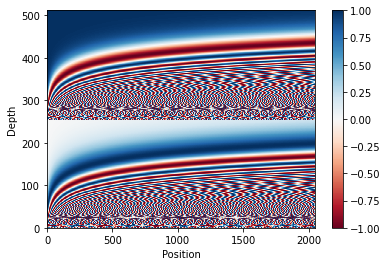

In [ ]:
# Plot the domensions
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

By definition these vectors align well with nearby vectors along the position axis. Below the position encoding vectors are normalized and the vector from position 1000 is compared, by dot-product, to all the others:

(0.0, 1.0)

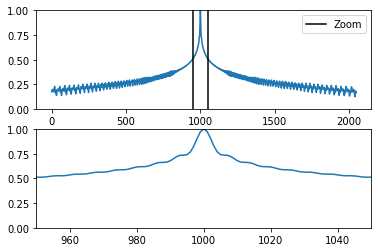

In [ ]:
pos_encoding /= tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)

plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

So use this to create a PositionEmbedding layer that looks-up a token's embedding vector and adds the position vector:

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()

    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]

    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positional_encoding
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    
    return x

In [ ]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [ ]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 81), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True]])>

## Add and normalize

<table>
<tr>
  <th colspan=2>Add and normalize</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Add+Norm.png"/>
  </td>
</tr>
</table>

These "Add & Norm" blocks are scattered throughout the model. Each one joins a residual connection and runs the result through a LayerNormalization layer.

The easiest way to organize the code is around these residual blocks. The following sections will define custom layer classes for each.

The residual "Add & Norm" blocks are included so that training is efficient. The residual connection provides a direct path for the gradient (and ensures that vectors are updated by the attention layers instead of replaced), while the normalization maintains a reasonable scale for the outputs.

In [ ]:
class AddNormLayer(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()

    self.add = tf.keras.layers.Add()
    self.norm = tf.keras.layers.LayerNormalization()

  def call(self, x, attn_output):
    x = self.add([x, attn_output])
    x = self.norm(x)

    return x

## The base attention layer

Attention layers are used throughout the model. These are all identical except for how the attention is configured. Each one contains a *layers.MultiHeadAttention* and a *AddNorm* layer.

<table>
<tr>
  <th colspan=2>The base attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention.png"/>
  </td>
</tr>
</table>

To implement these attention layers, start with a simple base class that just contains the component layers. Each use-case will be implemented as a subclass. It's a little more code to write this way, but it keeps the intention clear.

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()

    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.addnorm = AddNormLayer()

### Attention refresher

Before you get into the specifics of each usage, here is a quick refresher on how attention works:

<table>
<tr>
  <th colspan=1>The base attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention-new.png"/>
  </td>
</tr>
</table>

There are two inputs:

1.   The query sequence; the sequence being processed; the sequence doing the attending (bottom).
2.   The context sequence; the sequence being attended to (left).

The output has the same shape as the query-sequence.

The common comparison is that this operation is like a dictionary lookup. A fuzzy, differentiable, vectorized dictionary lookup.

## The Cross Attention layer

At the literal center of the Transformer is the cross-attention layer. This layer connects the encoder and decoder. This layer is the most straight-forward use of attention in the model, it performs the same task as the attention block in the NMT with attention tutorial.

<table>
<tr>
  <th colspan=1>The cross attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention.png"/>
  </td>
</tr>
</table>

To implement this you pass the target sequence x as the query and the context sequence as the key/value when calling the mha layer:

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query = x,
        key = context,
        value = context,
        return_attention_scores = True,
    )

    # Cache the attention scores for plotting later
    self.last_attn_scores = attn_scores

    x = self.addnorm(x, attn_output)
    return x

The caricature below shows how information flows through this layer. The columns represent the weighted sum over the context sequence.

For simplicity the residual connections are not shown.

<table>
<tr>
  <th>The cross attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
</table>

The output length is the length of the query sequence, but not on the length of the context key/value sequence.

The output length is the length of the `query` sequence, but not on the length of the context `key/value` sequence.

The diagram is farther simplified, below. There's no need to draw the entire "Attention weights" matrix.
The point is that each `query` location can see all the `key/value` pairs in the context, but no information is exchanged between the queries.

<table>
<tr>
  <th>Each query sees the whole context.</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new.png"/>
  </td>
</tr>
</table>

Test run it on sample inputs:

In [ ]:
sample_ca = CrossAttention(num_heads = 2, key_dim = 512)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 73, 512)
(64, 81, 512)
(64, 81, 512)


## The global Self Attention layer

This layer is responsible for processing the context sequence, and propagating information along its length:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png"/>
  </td>
</tr>
</table>

Since the context sequence is fixed while the translation is being generated, information is allowed to flow in both directions.

To implement this layer you just need to pass the target sequence, x, as both the query, and value arguments to the mha layer:

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query = x,
        value = x,
        key = x,
    )

    x = self.addnorm(x, attn_output)
    return x

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads = 2, key_dim = 512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 73, 512)
(64, 73, 512)


Sticking with the same style as before you could draw it like this:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new-full.png"/>
  </td>
</tr>
</table>

Again, the residual connections are omitted for clarity.

It's more compact, and just as accurate to draw it like this:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new.png"/>
  </td>
</tr>
</table>

## The Causal Self Attention layer

This layer does a similar job as the global self attention layer, for the output sequence:

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention.png"/>
  </td>
</tr>
</table>

This needs to be handled differently from the encoder's global self attention layer.

Transformers are an "autoregressive" models: They generate the text one token at a time and feed that output back to the input. To make this efficient, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal".

A causal model is efficient in two ways: 

1. In training, it lets you compute loss for every location in the output sequence while executing the model just once.
2. During inference, for each new token generated you only need to calculate its outputs, the outputs for the previous sequence elements can be reused.

To build a causal self attention layer, you need to use an appropriate mask when computing the attention scores and summing the attention `value`s.

This is taken care of automatically if you pass `use_causal_mask = True` to the `MultiHeadAttention` layer when you call it:

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query = x,
        value = x,
        key = x,
        use_causal_mask = True,
    )

    x = self.addnorm(x, attn_output)
    return x

The causal mask ensures that each location only has access to the locations that come before it:

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new-full.png"/>
  </td>
</tr>
</table>

Again, the residual connections are omitted for simplicity.

The more compact representation of this layer would be:

<table>
</tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new.png"/>
  </td>
</tr>
</table>

Test out the layer:

In [ ]:
sample_csa = CausalSelfAttention(num_heads = 2, key_dim = 512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 81, 512)
(64, 81, 512)


The output for early sequence elements doesn't depend on later elements, so it shouldn't matter if you trim elements before or after applying the layer:

In [ ]:
out1 = sample_csa(embed_en(en[:, :3])) 
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

4.7683716e-07

# The Feed Forward Network

The transformer also includes this point-wise feed-forward network in both the encoder and decoder:

<table>
<tr>
  <th colspan=1>The feed forward network</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>

The network consists of two linear layers (tf.keras.layers.Dense) with a ReLU activation in-between, and a dropout layer. As with the attention layers the code here also includes the residual connection and normalization:

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()

    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model),
        tf.keras.layers.Dropout(dropout_rate),
    ])
    self.addnorm = AddNormLayer()

  def call(self, x):
    x = self.addnorm(x, self.seq(x))
    return x

Test the layer, the output is the same shape as the input:

In [ ]:
sample_ffn = FeedForward(d_model = 512, dff = 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 81, 512)
(64, 81, 512)


## The encoder layer

The encoder contains a stack of `N` encoder layers. Where each `EncoderLayer` contains a `GlobalSelfAttention` and `FeedForward` layer:

<table>
<tr>
  <th colspan=1>The encoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png"/>
  </td>
</tr>
</table>

Here is the definition of the EncoderLayer:

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads = num_heads,
        key_dim = d_model,
        dropout = dropout_rate,
    )

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

And a quick test, the output will have the same shape as the input:

In [ ]:
sample_encoder_layer = EncoderLayer(d_model = 512, num_heads = 8, dff = 2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 73, 512)
(64, 73, 512)


## The encoder

Next build the encoder.

<table>
<tr>
  <th colspan=1>The encoder</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Encoder.png"/>
  </td>
</tr>
</table>

The encoder consists of:

*   A PositionalEmbedding layer at the input.
*   A stack of EncoderLayer layers.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(
        vocab_size = vocab_size,
        d_model = d_model,
    )
    self.enc_layers = [
        EncoderLayer(
            d_model = d_model,
            dff = dff,
            num_heads = num_heads,
            dropout_rate = dropout_rate,
        ) for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # 'x' is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x) # Shape '(batch_size, seq_len, d_model)'

    # Add dropout
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x # Shape '(batch_size, seq_len, d_model)'

Test the encoder:

In [ ]:
# Instatiate the encoder
sample_encoder = Encoder(num_layers=4, d_model=512, num_heads=8, dff=2048, vocab_size=8500)
sample_encoder_output = sample_encoder(pt, training=False)

print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 73)
(64, 73, 512)


## The decoder layer

The decoder's stack is slightly more complex, with each `DecoderLayer` containing a `CausalSelfAttention`, a `CrossAttention`, and a `FeedForward` layer:

<table>
<tr>
  <th colspan=1>The decoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png"/>
  </td>
</tr>
</table>

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads = num_heads,
        key_dim = d_model,
        dropout=dropout_rate,
    )
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate,
    )
    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x)
    x = self.cross_attention(x, context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x) # Shape '(batch_size, seq_len, d_model)'
    return x

Test the decoder layer:

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)
sample_decoder_layer_output = sample_decoder_layer(en_emb, pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # '(batch_size, seq_len, d_model)'

(64, 81, 512)
(64, 73, 512)
(64, 81, 512)


## The decoder

Similar to the `Encoder`, the `Decoder` consists of a `PositionalEmbedding`, and a stack of `DecoderLayer`s:

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Decoder.png"/>
  </td>
</tr>
</table>

Define the decoder by extending tf.keras.layers.Layer:

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size,
        d_model=d_model,
    )
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(
            d_model = d_model,
            num_heads = num_heads,
            dff = dff,
            dropout_rate = dropout_rate,
            ) for _ in range(num_layers)]
    self.last_attn_scores = None

  def call(self, x, context):
     # 'x' is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores
    # The shape of x is (batch_size, target_seq_len, d_model)
    return x

Test the decoder:

In [ ]:
# Instantiate the decoder
sample_decoder = Decoder(num_layers=4, d_model=512, num_heads=8, dff=2048, vocab_size=8000)
output = sample_decoder(en, pt_emb)

print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 81)
(64, 73, 512)
(64, 81, 512)


In [ ]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 81, 73])

Having created the Transformer encoder and decoder, it's time to build the Transformer model and train it.

# The Transformer

You now have `Encoder` and `Decoder`. To complete the `Transformer` model, you need to put them together and add a final linear (`Dense`) layer which converts the resulting vector at each location into output token probabilities. 

The output of the decoder is the input to this final linear layer.

<table>
<tr>
  <th colspan=1>The transformer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
</tr>
</table>

A `Transformer` with one layer in both the `Encoder` and `Decoder` looks almost exactly like the model from the [RNN+attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention). A multi-layer Transformer has more layers, but is fundamentally doing the same thing.

<table>
<tr>
  <th colspan=1>A 1-layer transformer</th>
  <th colspan=1>A 4-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-compact.png"/>
  </td>
  <td rowspan=3>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The RNN+Attention model</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-compact.png"/>
  </td>
</tr>
</table>

Create the Transformer by extending tf.keras.Model:

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()

    self.encoder = Encoder(
        num_layers = num_layers,
        d_model = d_model,
        num_heads = num_heads,
        dff = dff,
        vocab_size = input_vocab_size,
        dropout_rate = dropout_rate,
    )
    self.decoder = Decoder(
        num_layers = num_layers,
        d_model = d_model,
        num_heads = num_heads,
        dff = dff,
        vocab_size = target_vocab_size,
        dropout_rate = dropout_rate,
    )
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with '.fit' you must pass all your inputs in the first argument.
    context, x = inputs

    context = self.encoder(context) # (batch_size, context_len, d_model)
    x = self.decoder(x, context) # (batch_size, target_len, d_model)

    # Final linear layer output
    logits = self.final_layer(x)
    return logits


## Hyperparameters

To keep this example small and relatively fast, the number of layers (`num_layers`), the dimensionality of the embeddings (`d_model`), and the internal dimensionality of the `FeedForward` layer (`dff`) have been reduced.

The base model described in the original Transformer paper used `num_layers=6`, `d_model=512`, and `dff=2048`.

The number of self-attention heads remains the same (`num_heads=8`).

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

## Try it out

Instantiate the Transformer model

In [ ]:
transformer = Transformer(
    num_layers = num_layers,
    d_model = d_model,
    num_heads = num_heads,
    dff = dff,
    input_vocab_size = tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size = tokenizers.en.get_vocab_size().numpy(),
    dropout_rate = dropout_rate,
)

Test it:

In [ ]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 81)
(64, 73)
(64, 81, 7010)


In [ ]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores

print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 81, 73)


Print the summary of the model:

In [ ]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3632768   
                                                                 
 decoder_1 (Decoder)         multiple                  5647104   
                                                                 
 dense_38 (Dense)            multiple                  904290    
                                                                 
Total params: 10,184,162
Trainable params: 10,184,162
Non-trainable params: 0
_________________________________________________________________


# Training

It's time to prepare the model and start training it.

## Set up the optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Instantiate the optimizer (in this example it's *tf.keras.optimizers.Adam*):

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Test the custom learning rate scheduler:

Text(0.5, 0, 'Train Step')

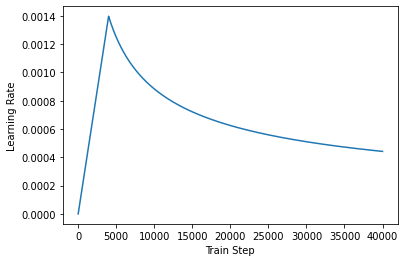

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## Set up the loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss. Use the cross-entropy loss function (*tf.keras.losses.SparseCategoricalCrossentropy*):

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits = True,
      reduction = 'none',
  )
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
  return loss

In [ ]:
def masked_acc(label, pred):
  pred = tf.argmax(pred, axis = 2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0
  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return  tf.reduce_sum(match) / tf.reduce_sum(mask)

## Train the model

With all the components ready, configure the training procedure using model.compile, and then run it with model.fit:

Note: This takes about an hour to train in Colab.

In [ ]:
transformer.compile(
    loss = masked_loss,
    optimizer = optimizer,
    metrics = [masked_acc],
)

In [ ]:
transformer.fit(
    train_batches,
    epochs = 10,
    validation_data = val_batches,
)

Epoch 1/10
810/810 [==============================] - 339s 358ms/step - loss: 6.5966 - masked_acc: 0.1410 - val_loss: 5.0512 - val_masked_acc: 0.2467
Epoch 2/10
810/810 [==============================] - 209s 258ms/step - loss: 4.5630 - masked_acc: 0.2995 - val_loss: 4.0505 - val_masked_acc: 0.3588
Epoch 3/10
810/810 [==============================] - 198s 244ms/step - loss: 3.8158 - masked_acc: 0.3795 - val_loss: 3.4143 - val_masked_acc: 0.4335
Epoch 4/10
810/810 [==============================] - 190s 234ms/step - loss: 3.2815 - masked_acc: 0.4371 - val_loss: 3.0074 - val_masked_acc: 0.4835
Epoch 5/10
810/810 [==============================] - 188s 232ms/step - loss: 2.8823 - masked_acc: 0.4825 - val_loss: 2.7654 - val_masked_acc: 0.5116
Epoch 6/10
810/810 [==============================] - 191s 235ms/step - loss: 2.5651 - masked_acc: 0.5209 - val_loss: 2.4889 - val_masked_acc: 0.5502
Epoch 7/10
810/810 [==============================] - 190s 234ms/step - loss: 2.2925 - masked_acc: 0

# Run Inference

You can now test the model by performing a translation. The following steps are used for inference:

*   Encode the input sentence using the Portuguese tokenizer (tokenizers.pt). This is the encoder input.
*   The decoder input is initialized to the [START] token.
*   Calculate the padding masks and the look ahead masks.
*   The decoder then outputs the predictions by looking at the encoder output and its own output (self-attention).
*   Concatenate the predicted token to the decoder input and pass it to the decoder.
*   In this approach, the decoder predicts the next token based on the previous tokens it predicted.

Note: The model is optimized for efficient training and makes a next-token prediction for each token in the output simultaneously. This is redundant during inference, and only the last prediction is used. This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (training=False).

Define the Translator class by subclassing tf.Module:

In [ ]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Por, hence adding the '[START]' and '[END]' tokens
    assert isinstance(sentence, tf.Tensor)

    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()
    encoder_input = sentence

    # As the output language is Eng, initialize the output with the English '[START]' token
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end= start_end[-1][tf.newaxis]

    # 'tf.TensorArray' is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by 'tf.function'.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the 'seq_len' dimension
      predictions = predictions[:, -1:, :] # Shape '(batch_size, 1, vocab_size)'
      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the 'predicted_id' to the output which is given to the decoder as its input
      output_array = output_array.write(i+1, predicted_id[0])    

      if predicted_id == end:
        break

    output =  tf.transpose(output_array.stack())
    
    # The output shape is '(1, tokens)'
    text = tokenizers.en.detokenize(output)[0]
    tokens = tokenizers.en.lookup(output)[0]

    # 'tf.function' prevents us from using the attention_weights that were calculated on the
    # last iteration of the loop. So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:, :-1]], training=False)
    attention_weigths = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weigths

Note: This function uses an unrolled loop, not a dynamic loop. It generates MAX_TOKENS on every call. Refer to the NMT with attention tutorial for an example implementation with a dynamic loop, which can be much more efficient.

Create an instance of this Translator class, and try it out a few times:

In [ ]:
translator = Translator(tokenizers, transformer)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

Example 1

In [ ]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

tranlated_text, translated_tokens, attention_weigths = translator(tf.constant(sentence))
print_translation(sentence, tranlated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


Example 2:

In [ ]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

tranlated_text, translated_tokens, attention_weigths = translator(tf.constant(sentence))
print_translation(sentence, tranlated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors have heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


Example 3:

In [ ]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

tranlated_text, translated_tokens, attention_weigths = translator(tf.constant(sentence))
print_translation(sentence, tranlated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m very quickly going to share with you some stories of some magic things that happen .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


# Create attention plots

The Translator class you created in the previous section returns a dictionary of attention heatmaps you can use to visualize the internal working of the model.

In [ ]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


Create a function that plots the attention when a token is generated:

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate the '[START]' token in the output. Skip it
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [ ]:
head = 0

# Shape: '(batch=1, num_heads, seq_len_q, seq_len_k)'
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

These are the input (Portuguese) tokens:

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

And these are the output (English translation) tokens:

In [ ]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'did', b'.', b'[END]'], dtype=object)>

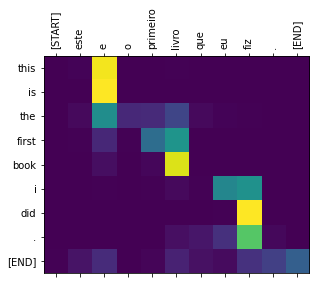

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize = (16, 8))
  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)
    plot_attention_head(in_tokens, translated_tokens, head)
    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

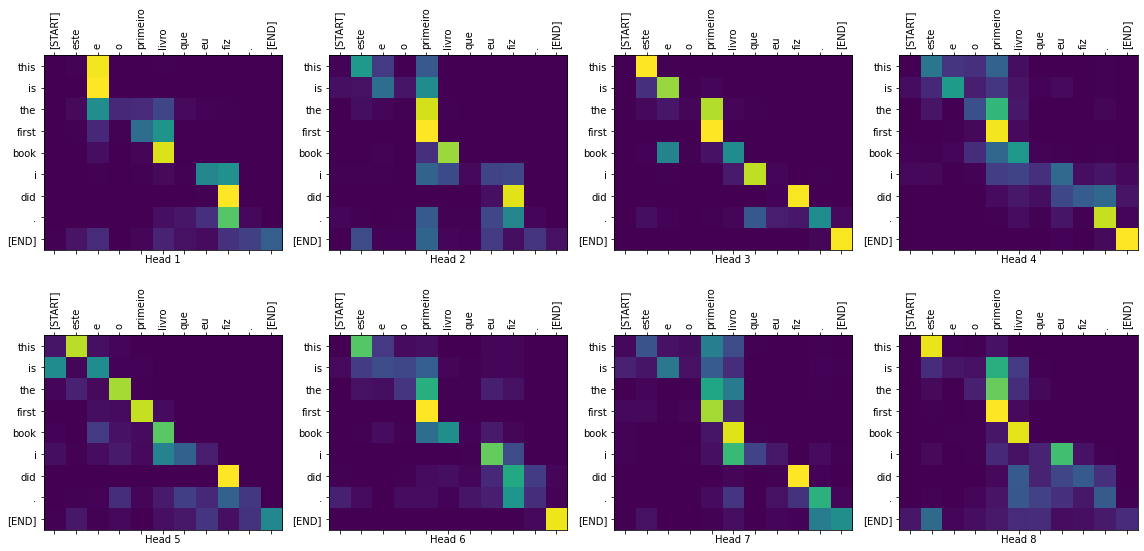

In [ ]:
plot_attention_weights(sentence, translated_tokens, attention_weights[0])

The model can handle unfamiliar words. Neither 'triceratops' nor 'encyclopédia' are in the input dataset, and the model attempts to transliterate them even without a shared vocabulary. For example:

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about trivas on the encycloody .
Ground truth   : I read about triceratops in the encyclopedia.


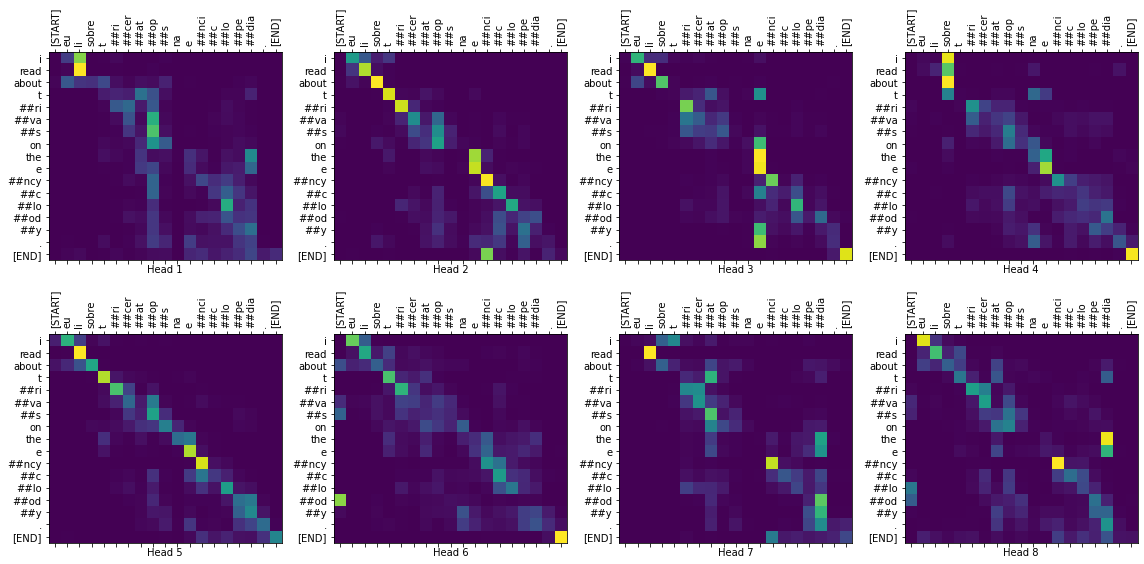

In [ ]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

# Export the model

You have tested the model and the inference is working. Next, you can export it as a tf.saved_model.

Create a class called ExportTranslator by subclassing the *tf.Module* subclass with a *tf.function* on the *__call__* method:

In [ ]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result, tokens, attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)
    return result

In the above *tf.function* only the output sentence is returned. Thanks to the non-strict execution in *tf.function* any unnecessary values are never computed.

Wrap translator in the newly created ExportTranslator:

In [ ]:
translator = ExportTranslator(translator)

Since the model is decoding the predictions using tf.argmax the predictions are deterministic. The original model and one reloaded from its SavedModel should give identical predictions:

In [ ]:
translator('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

In [ ]:
tf.saved_model.save(translator, export_dir='translator')

In [ ]:
reloaded = tf.saved_model.load('translator')

In [ ]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

## Download the model

First zip the model folder

In [ ]:
!zip -r /content/model.zip /content/translator

  adding: content/translator/ (stored 0%)
  adding: content/translator/saved_model.pb (deflated 77%)
  adding: content/translator/fingerprint.pb (stored 0%)
  adding: content/translator/variables/ (stored 0%)
  adding: content/translator/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/translator/variables/variables.index (deflated 79%)
  adding: content/translator/assets/ (stored 0%)
  adding: content/translator/assets/en_vocab.txt (deflated 54%)
  adding: content/translator/assets/pt_vocab.txt (deflated 57%)


Download it from Google Colab

In [ ]:
from google.colab import files
files.download("/content/model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>